广义上讲，当样本数为n，特征数为d时，线性回归的矢量计算表达式为
$$\hat{y} = X\omega + b$$

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

#生成数据集
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

/var/folders/rv/7f6t6x35371gkm3gtkytkxbm0000gn/T/ipykernel_14808/996866783.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


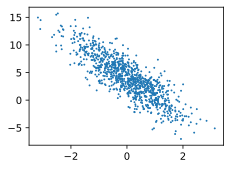

In [2]:
#展示features和labels之间的线性关系

def use_svg_display():
    """用矢量图表示"""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """设置图的尺寸"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize


set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)



在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本，定义一个函数，每次返回`batch_size`个随机样本的特征和标签

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 随机读取样本
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

batch_size = 10

In [6]:
# 初始化模型参数
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

# 由于需要对参数求梯度来迭代，所以需要记录梯度
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

# 定义模型
def linreg(X, w, b):
    return torch.mm(X, w) + b

# 定义损失函数
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2

# 定义优化算法
def sgd(params, lr, batch_size):
    """实现小批量随机梯度下降算法"""
    for param in params:
        param.data -= lr * param.grad / batch_size

在训练中，每次读取小批量数据样本对模型进行迭代，通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数，需要注意由于每个小批量损失`l`的形状为(10, 1)，所以我们可以调用`.sum()`将其求和得到一个标量，再运行`l.backward()`得到模型参数的梯度，另外需要注意每次更新完参数需要将参数的梯度清零

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数

In [7]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()
        l.backward()
        sgd([w, b], lr, batch_size)

        # 清零梯度
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.000468
epoch 2, loss 0.000102
epoch 3, loss 0.000103


In [8]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0001],
        [-3.3996]], requires_grad=True)
4.2 
 tensor([4.2010], requires_grad=True)


线性模型的简单实现

In [9]:
import torch.utils.data as Data
import torch.nn as nn

batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

# 定义模型
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)

    # 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


事实上还可以使用`nn.Sequential`来方便的搭建网络，`Sequential`是一个有序的容器，网络层将按照在传入`Sequential`的顺序依次被添加到计算图中

In [10]:
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
)

可以通过`net.parameters()`来查看模型所有的可学习参数，此函数将返回一个生成器

In [12]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0077, -0.0175]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [13]:
# 初始化模型参数
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)

Parameter containing:
tensor([0.], requires_grad=True)

In [14]:
# 定义损失函数
loss = nn.MSELoss()

# 定义优化算法
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


还可以为不同子网络设置不同的学习率
```Python
optimizer =optim.SGD([
                # 如果对某个参数不指定学习率，就使用最外层的默认学习率
                {'params': net.subnet1.parameters()}, # lr=0.03
                {'params': net.subnet2.parameters(), 'lr': 0.01}
            ], lr=0.03)

```

In [15]:
# 训练模型
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))


epoch 1, loss: 0.000216
epoch 2, loss: 0.000057
epoch 3, loss: 0.000105
